In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras.layers as layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint

2024-05-02 19:15:54.471539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 19:15:54.471641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 19:15:54.594679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# electrode_names = [
#     "FP1", "FPz", "FP2", "AFp1", "AFPz", "AFp2", "AF7", "AF3", "AF4", "AF8",
#     "AFF5h", "AFF1h", "AFF2h", "AFF6h", "F9", "F7", "F5", "F3", "F1", "Fz",
#     "F2", "F4", "F6", "F8", "F10", "FFT9h", "FFT7h", "FFC5h", "FFC3h", "FFC1h",
#     "FFC2h", "FFC4h", "FFC6h", "FFT8h", "FFT10h", "FT9", "FT7", "FC5", "FC3",
#     "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "FT10", "FTT9h", "FTT7h", "FCC5h",
#     "FCC3h", "FCC1h", "FCC2h", "FCC4h", "FCC6h", "FTT8h", "FTT10h", "T7", "C5",
#     "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TTP7h", "CCP5h", "CCP3h", "CCP1h",
#     "CCP2h", "CCP4h", "CCP6h", "TTP8h", "TP9", "TP7", "CP5", "CP3", "Cpz", "CP4",
#     "CP6", "TP8", "TP10", "TPP9h", "TPP7h", "CPP5h", "CPP3h", "CPP1h", "CPP2h",
#     "CPP4h", "CPP6h", "TPP8h", "TPP10h", "P9", "P7", "P5", "P3", "P1", "Pz", "P2",
#     "P4", "P6", "P8", "P10", "PPO9h", "PPO5h", "PPO1h", "PPO2h", "PPO6h", "PPO10h",
#     "PO9", "PO7", "PO3", "POz", "PO4", "PO8", "PO10", "POO9h", "POO1", "POO2",
#     "POO10h", "O1", "Oz", "O2", "OI1h", "OI2h", "I1", "Iz", "I2"
# ]

# num_electrodes = len(electrode_names)

NUM_CHANNELS_TO_LOAD = 128
DATA_SIZE = 60_000
SIGNAL_LENGTH = 167
BATCH_SIZE = 128

In [3]:
def load_in_order(cz: int):
    dataset = np.zeros((DATA_SIZE, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH), dtype=np.int32)
    labels = np.zeros(DATA_SIZE, dtype=np.int8)
    
    i = 0
    for chunk in tqdm(pd.read_csv('/kaggle/input/processed-train/processed_train.csv', chunksize=cz)):
        chunk = chunk[chunk['label'] != -1]
        l = chunk['label'].to_numpy()
        o = chunk.shape[0]
        labels[i:i+o] = l
        dataset[i:i+o] = chunk.iloc[:, :-2].to_numpy().reshape(-1, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH)
        i += o
    return labels, dataset
        

labels, datasets = load_in_order(1_000)

61it [10:27, 10.29s/it]


In [4]:
session_nums = pd.read_csv('/kaggle/input/mindbigdata2023-mnist-8b/train.csv', usecols=['label', 'sessionnum'])
session_nums = session_nums.to_numpy()

In [5]:
session_nums = session_nums[session_nums[:,0]!=-1][:,1]

In [6]:
sesh_data = {sesh:{'mean': np.mean(datasets[session_nums == sesh]), 'std': np.std(datasets[session_nums == sesh])} 
 for sesh in np.unique(session_nums)}
sesh_data

{0: {'mean': 39.03792851796407, 'std': 9023.286045285138},
 1: {'mean': 1328.1925486526945, 'std': 14576.540891465806},
 2: {'mean': 51.94376129415925, 'std': 14550.659943499359},
 3: {'mean': 232.66916773071503, 'std': 10405.774918529361},
 4: {'mean': 219.5900105726048, 'std': 8784.213498951172},
 5: {'mean': 1790.9829975465734, 'std': 28065.30308923119},
 6: {'mean': 235.36004865269462, 'std': 34387.997285728154},
 7: {'mean': 911.6657783697311, 'std': 12842.532965745473},
 8: {'mean': 953.526959062644, 'std': 12138.891981572737},
 9: {'mean': 679.569003399451, 'std': 9550.37418945668},
 10: {'mean': 1682.9322460847536, 'std': 34496.856177914575},
 11: {'mean': 697.8279081680389, 'std': 21331.839663515948},
 12: {'mean': 492.4352601047904, 'std': 9660.09606430828},
 13: {'mean': 711.0830673212399, 'std': 20705.90440557397},
 14: {'mean': 638.6611038901926, 'std': 16093.106949051167},
 15: {'mean': 95.92246693322217, 'std': 26466.45508111274},
 16: {'mean': 1196.8387673871007, 'std':

In [7]:
for sesh in sesh_data.keys():
    datasets[session_nums==sesh] = (datasets[session_nums==sesh] - sesh_data[sesh]['mean'])/sesh_data[sesh]['std']

In [8]:
from keras import regularizers

input_data = layers.Input((NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH))
# x = layers.Rescaling(1/30000)(input_data)
x = layers.Conv1D(16, 16, activation='leaky_relu', data_format='channels_first', padding='same',
                  kernel_regularizer=regularizers.L1L2(l1=0, l2=0))(input_data)
x = layers.MaxPooling1D(2)(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='leaky_relu', kernel_regularizer=regularizers.L1L2(l1=0, l2=0))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(10, activation='softmax')(x)
model = Model(input_data, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.save_weights('/kaggle/working/best_model.weights.h5')

In [9]:
from sklearn.model_selection import train_test_split
train, test, train_y, test_y = train_test_split(datasets, labels, test_size=0.2, random_state=42, shuffle=True)
history = model.fit(train, train_y, validation_data=(test, test_y), batch_size=128, epochs=50)

Epoch 1/50
 21/375 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0878 - loss: 3.0990

I0000 00:00:1714679259.771361      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.0997 - loss: 2.6068 - val_accuracy: 0.1028 - val_loss: 2.3604
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1120 - loss: 2.3497 - val_accuracy: 0.1085 - val_loss: 2.3295
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1212 - loss: 2.3238 - val_accuracy: 0.1054 - val_loss: 2.3293
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1346 - loss: 2.3019 - val_accuracy: 0.1033 - val_loss: 2.3197
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1468 - loss: 2.2772 - val_accuracy: 0.1050 - val_loss: 2.3241
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1661 - loss: 2.2490 - val_accuracy: 0.1045 - val_loss: 2.3458
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1853 - loss: 2.2177 - val_accuracy: 0.1051 - val_loss: 2.3683
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2092 - loss: 2.1776 - val_accuracy: 0.1044 - va

Text(0.5, 1.0, 'Accuracy during Training')

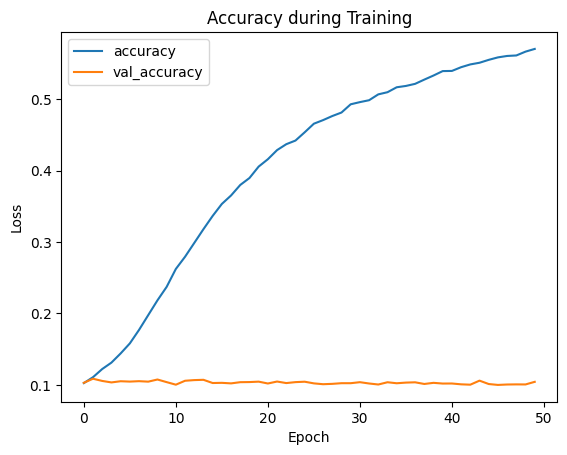

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Accuracy during Training")

In [11]:
train, test, train_y, test_y = train_test_split(datasets, labels, test_size=0.2, shuffle=False)
model = Model(input_data, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.load_weights('/kaggle/working/best_model.weights.h5')
history = model.fit(train, train_y, validation_data=(test, test_y), batch_size=128, epochs=50)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.1021 - loss: 2.5888 - val_accuracy: 0.1018 - val_loss: 2.3345
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1130 - loss: 2.3479 - val_accuracy: 0.1022 - val_loss: 2.3635
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1201 - loss: 2.3211 - val_accuracy: 0.1058 - val_loss: 2.3213
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1337 - loss: 2.2989 - val_accuracy: 0.1005 - val_loss: 2.3235
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1451 - loss: 2.2801 - val_accuracy: 0.1007 - val_loss: 2.3293
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1646 - loss: 2.2518 - val_accuracy: 0.0976 - val_loss: 2.3330
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1854 - loss: 2.2212 - val_accuracy: 0.1027 - val_loss: 2.3535
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2064 - loss: 2.1842 - val_accuracy: 0

Text(0.5, 1.0, 'Accuracy during Training')

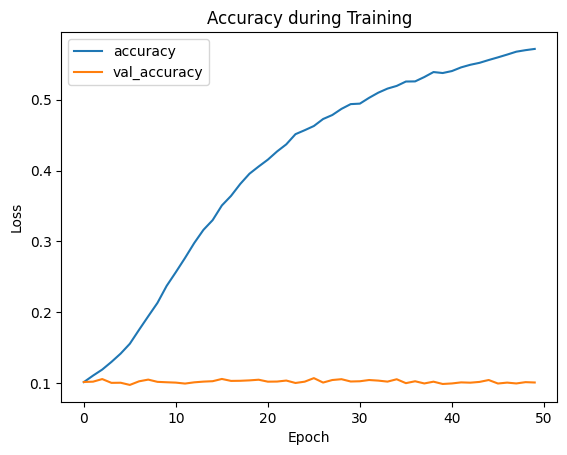

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Accuracy during Training")